In [161]:
import sys
print("Python Version:", sys.version)
import statistics
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 500)
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
sns.set()


import scipy.stats as scs
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from wordcloud import WordCloud, STOPWORDS 


import warnings
warnings.filterwarnings('ignore')

Python Version: 3.7.7 (default, Mar 23 2020, 17:31:31) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


# Setting up the Data

In [2]:
df_raw_wine = pd.read_csv('Wine_Data/kaggle_wine.csv')
df_wine = df_raw_wine.iloc[:,1:]
len(df_wine)

150930

In [3]:
df_wine.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


This data set contains 150,930 reviews with a wines points, price, telescoping location information, and relatively lengthy descriptions.

In [4]:
df_wine['description'][0]

'This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.'

The Most important data from this data set seems to be the description.

In [5]:
df_us = df_wine[df_wine['country'] == 'US']
df_fr = df_wine[df_wine['country'] == 'France']
df_wine2 = pd.concat([df_us, df_fr])
df_wine2.reset_index(drop = True, inplace = True)

To make this a manageable process, we will stick to United States vs. France in a traditional Old World vs. New World cook-off. We will try to classify based on descriptions and scores.  

In [6]:
df_wine2.sample(10)

,country,description,designation,points,price,province,region_1,region_2,variety,winery
22360,US,"Tough and common, with ripe, candied flavors o...",Aria,83,39.0,California,Paso Robles,Central Coast,Bordeaux-style Red Blend,Harmony Cellars
55765,US,"This low-alcohol (10.4%) dessert wine, finishe...",Late Harvest Reserve,92,19.0,Washington,Rattlesnake Hills,Columbia Valley,Sauvignon Blanc,Silver Lake
68219,France,Belcier is on the slope that continues east fr...,B de Belcier,90,40.0,Bordeaux,Castillon Côtes de Bordeaux,NaN,Bordeaux-style Red Blend,Château de Belcier
13169,US,"Not quite ripe, with a vegetal, herbal edge to...",River Ranch,85,40.0,California,Russian River Valley,Sonoma,Pinot Noir,Renteria
12692,US,"Leather, pencil shavings and cedar provide an ...",NaN,89,50.0,California,Napa Valley,Napa,Cabernet Sauvignon,Crossbarn Paul Hobbs
2000,US,"A solid wine for the price, this often sells f...",NaN,88,16.0,California,Paso Robles,Central Coast,Cabernet Sauvignon,Liberty School
25540,US,"This is Talley's basic appellation Pinot Noir,...",Estate,87,34.0,California,Arroyo Grande Valley,Central Coast,Pinot Noir,Talley
59284,US,"Oddly sweet and medicinal, with sugary apricot...",NaN,80,15.0,California,Lodi,Central Valley,Viognier,King
28103,US,"Good, tangy red fruit, with youthful vigor and...",NaN,88,28.0,California,Sonoma County,Sonoma,Zinfandel,Grgich Hills
37056,US,"Oak dominates this wine, giving it toast and v...",Allomi,85,28.0,California,Napa Valley,Napa,Cabernet Sauvignon,Hess


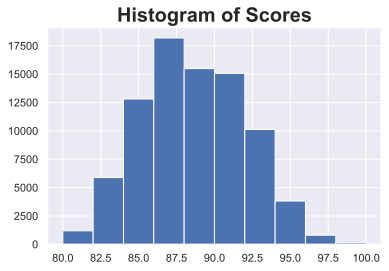

In [7]:
plt.hist(df_wine2.points)
plt.title('Histogram of Scores', fontweight="bold", fontsize=20);

The scores look fairly normal here.

In [8]:
grapes = df_wine2['variety'].value_counts()
grapes.head()

Pinot Noir                  12413
Chardonnay                  11019
Cabernet Sauvignon           9228
Bordeaux-style Red Blend     6792
Syrah                        4732
Name: variety, dtype: int64

Just to keep the problem simple at first, we will try to stick to one grape. Chardonnay seems to have plenty of data and is well split up. With some domain knowledge (if appreciating wine is knowledge),we should go ahead and check the grape types for any appelations that may be Chardonnay grapes produced in certain regions of France. As you can see below, we sifted through the grape types and they have already set everything to its common grape type name. 

In [9]:
df_chard = df_wine2[df_wine2['variety'] == 'Chardonnay']
df_chard.reset_index(drop = True, inplace = True)
df_chard['country'].value_counts()

US        8127
France    2892
Name: country, dtype: int64

To predict the location of the scardonnay, we need to add entries for each wine designating words it may or may not contain. Using standard conventions, we designate 1 if the description contains a given word and 0 if it does not. Our goal here is to quantify the description section using some keywords which we have picked. If you are interested in the code, we wrote functions in the "word_finder.ipynb" notebook that are applied to the description column of our dataframe df_chard. The output will be a dataframe with 50 new columns with column names designating the word.

In [79]:
#Here are some functions to pull words from descriptions
from ipynb.fs.full.word_finder_chard import *   
#Add columns:
word_finder_matrix(df_chard)
df_chard.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,...,baking spices,cinnamon,nutmeg,peach,pineapple,papaya,sharp,dull,grass,licorice
0,US,"First made in 2006, this succulent luscious Ch...",Sigrid,95,90.0,Oregon,Willamette Valley,Willamette Valley,Chardonnay,Bergström,...,0,0,0,0,0,0,0,0,0,0
1,US,The apogee of this ambitious winery's white wi...,Giallo Solare,95,60.0,California,Edna Valley,Central Coast,Chardonnay,Center of Effort,...,0,0,0,0,0,0,0,0,0,0
2,US,"Steely and perfumed, this wine sees only 20% n...",Babushka,90,37.0,California,Russian River Valley,Sonoma,Chardonnay,Zepaltas,...,0,0,0,0,0,0,0,0,0,0
3,US,"The aromas entice with notes of wet stone, hon...",Conner Lee Vineyard,90,42.0,Washington,Columbia Valley (WA),Columbia Valley,Chardonnay,Buty,...,0,0,0,0,0,0,0,0,0,0
4,US,There's a lot to like in this nicely priced wh...,NaN,90,18.0,California,Russian River Valley,Sonoma,Chardonnay,De Loach,...,0,0,0,0,0,0,0,0,0,0


There we have it! We picked 50 words and created a matrix to predict if these chardonnays are New World or Old World. We can make a quick plot and word cloud to find  of the 50 words which are the most popular.

In [11]:
word_counts = df_chard.iloc[:,10:].sum(axis = 0)
word_counts = word_counts.sort_values(ascending = False)

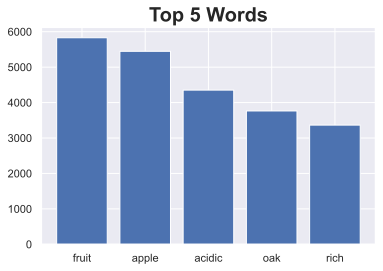

In [12]:
plt.bar(word_counts.index[0:5],word_counts.values[0:5])
plt.title('Top 5 Words', fontweight="bold", fontsize=20);

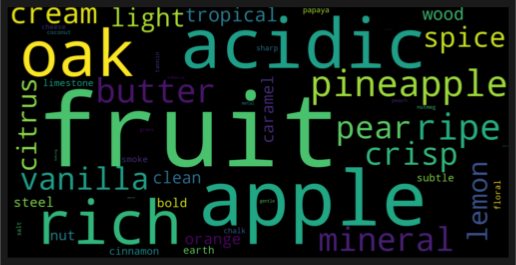

In [13]:
word_string = '' 
for i in range(50):
    new_string = ' ' + word_counts.index[i] + ' '
    word_string += (new_string * word_counts.values[i])

wordcloud_counts = WordCloud(width=1600, height=800,collocations=False).generate(word_string)
plt.figure(figsize = (9,9), facecolor='k')
plt.imshow(wordcloud_counts, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud.png', facecolor='k', bbox_inches='tight');

# A Few Models

Like any model, the first thing to do before we prepare a model is to split our data into test and train.

In [14]:
binary_features = df_chard.iloc[:,10:]
target = df_chard['country']
X_train, X_test, y_train, y_test = train_test_split(binary_features,target,test_size = 0.20)

We'll start with k-nearest neighbors and see if fe can find out which k works best.

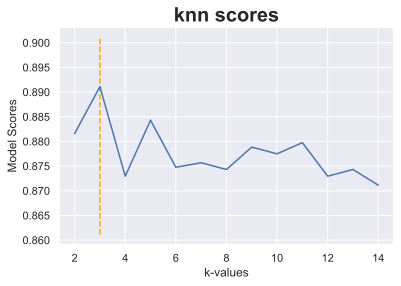

In [15]:
ks = range(2,15)
enumerated_ks =[]
for i in ks:
    knn_test = KNeighborsClassifier(n_neighbors = i)
    knn_test.fit(X_train,y_train)
    enumerated_ks.append(knn_test.score(X_test,y_test))

plt.plot(range(2,15),enumerated_ks)
plt.xlabel('k-values')
plt.ylabel('Model Scores')
plt.title('knn scores',fontweight="bold", fontsize=20)
plt.vlines(x=[3],ymin=min(enumerated_ks)-0.01,ymax=max(enumerated_ks)+0.01,linestyles='dashed', 
           color = 'orange', label=['3']);

It looks like 3 is going to give us the best fit!

In [16]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [17]:
knn.score(X_train,y_train)

0.9403289846851957

In [18]:
knn.score(X_test,y_test)

0.8911070780399274

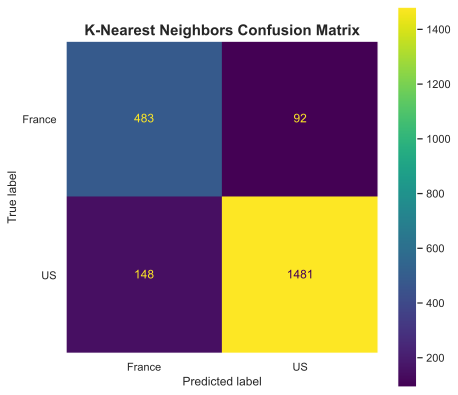

In [19]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(knn, X_test, y_test, ax=ax)
plt.grid(b = None)
plt.title('K-Nearest Neighbors Confusion Matrix',fontweight="bold", fontsize=15);

The confusion matrix shows us that KNN is working really well for US (shocker because 73.75% of the desriptions are US wines) and isn't too bad at the French wines either! We also should note that k-neighbors tends to overfit a good ammount. Let's give Logistic Regression a try.

In [181]:
scores = []
for i in range(1,50):
    logit_sc = LogisticRegression(C=i,solver = 'liblinear')
    logit_sc.fit(X_train,y_train)
    scores.append(logit_sc.score(X_test,y_test))
scores

[0.8706896551724138,
 0.8729582577132486,
 0.8738656987295825,
 0.8738656987295825,
 0.8738656987295825,
 0.8738656987295825,
 0.8738656987295825,
 0.8738656987295825,
 0.8738656987295825,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782214156,
 0.8734119782

So it appears that the "C" parameter to help not overfit doesn't make a huge difference in our situation. 

In [182]:
logistic = LogisticRegression(C=3,solver='liblinear')
logistic.fit(X_train, y_train);

In [183]:
logistic.score(X_train,y_train)

0.8820192853091322

In [184]:
logistic.score(X_test,y_test)

0.8738656987295825

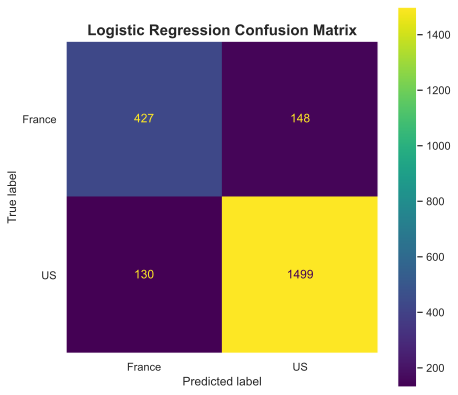

In [185]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(logistic, X_test, y_test, ax=ax)
plt.grid(b = None)
plt.title('Logistic Regression Confusion Matrix', fontweight="bold", fontsize=15);

Let's try a Naive Bayes' for a change of pace. These other algorithms are overfitting a little bit. We'll be using the Bernouli method.

In [186]:
NB_bern = BernoulliNB()
NB_bern.fit(X_train,y_train)
NB_bern.score(X_train,y_train)

0.862507090187181

In [187]:
NB_bern.score(X_test,y_test)

0.8502722323049002

Atleast we know this model really doesn't seem to overfit at all!

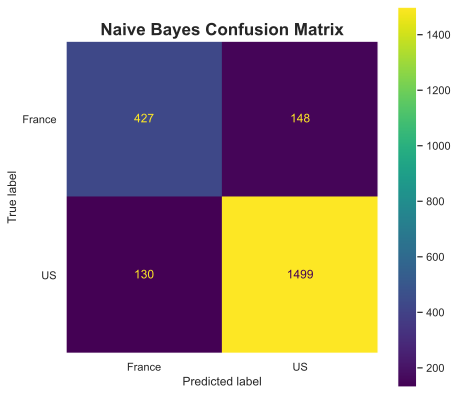

In [188]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(logistic, X_test, y_test, ax=ax)
plt.grid(b = None)
plt.title('Naive Bayes Confusion Matrix', fontweight="bold", fontsize=17);

We can also do support vector machines.

In [189]:
from sklearn.svm import SVC
svc = SVC(probability = True)
svc.fit(X_train, y_train)
svc.score(X_train,y_train)

0.9250141803743619

In [190]:
svc.score(X_test,y_test)

0.8997277676950998

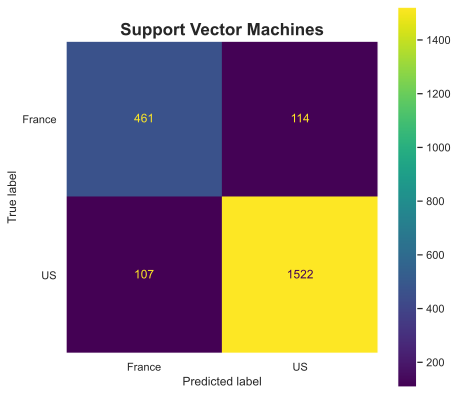

In [191]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(svc, X_test, y_test, ax=ax)
plt.grid(b = None)
plt.title('Support Vector Machines', fontweight="bold", fontsize=17);

This is a decision tree. We will see it's really good but definitely overfits!

In [192]:
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train,y_train)
decisiontree.score(X_train,y_train)

0.9748156551332955

In [193]:
decisiontree.score(X_test,y_test)

0.911978221415608

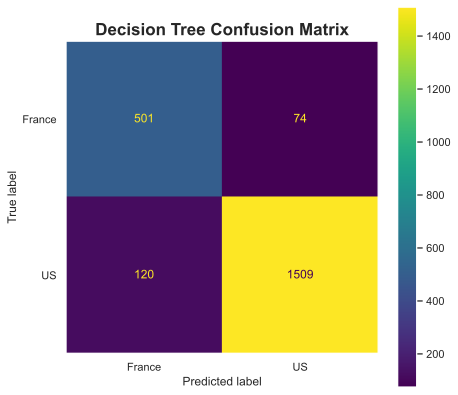

In [194]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(decisiontree, X_test, y_test, ax=ax)
plt.grid(b = None)
plt.title('Decision Tree Confusion Matrix', fontweight="bold", fontsize=17);

It's pretty good! But there is a better version of this model. Incomes the random forest model. Sometimes this bad larry works really well.

In [195]:
forest=RandomForestClassifier(n_estimators=100)
forest.fit(X_train,y_train)
y_pred=forest.predict(X_test)
forest.score(X_train,y_train)

0.9748156551332955

In [196]:
forest.score(X_test,y_test)

0.9296733212341198

This looks really good!

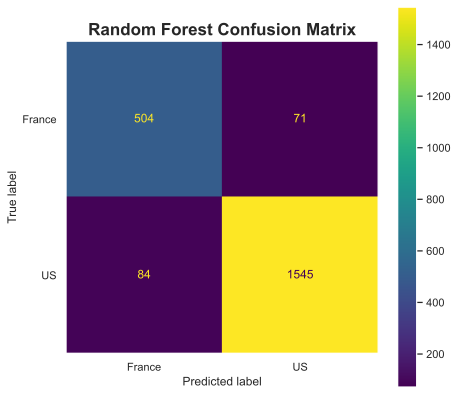

In [197]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(forest, X_test, y_test, ax=ax)
plt.grid(b = None)
plt.title('Random Forest Confusion Matrix', fontweight="bold", fontsize=17);

This one looks like the best so far!! Let's go ahead and check the ROC curves and the AUC scores for all of the classifiers. Then we can have a true comparison.

In [198]:
y_test_bin = y_test.map({'France': 0, 'US': 1})
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test_bin, knn.predict_proba(X_test)[:,1])
fpr_log, tpr_log, thresholds_log = roc_curve(y_test_bin, logistic.predict_proba(X_test)[:,1])
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test_bin, NB_bern.predict_proba(X_test)[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_bin, forest.predict_proba(X_test)[:,1])
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test_bin, svc.predict_proba(X_test)[:,1])
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test_bin, decisiontree.predict_proba(X_test)[:,1])

KNN ROC AUC score =  0.941489310593322
Logit ROC AUC score =  0.9391960925614541
Naive Bayes ROC AUC score =  0.9275997544505832
Random Forest ROC AUC score =  0.9745648170389944
Support Vector Machines ROC AUC score =  0.9524562948728214
Decision Tree ROC AUC score =  0.9172215549683722


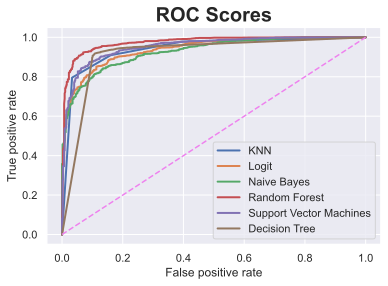

In [199]:
plt.plot(fpr_knn, tpr_knn,lw=2)
plt.plot(fpr_log, tpr_log,lw=2)
plt.plot(fpr_nb, tpr_nb,lw=2)
plt.plot(fpr_rf, tpr_rf,lw=2)
plt.plot(fpr_svc, tpr_svc,lw=2)
plt.plot(fpr_dt, tpr_dt,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Scores', fontweight="bold", fontsize=20);
plt.legend(['KNN','Logit', 'Naive Bayes', 'Random Forest', 'Support Vector Machines', 'Decision Tree'])
print("KNN ROC AUC score = ", roc_auc_score(y_test, knn.predict_proba(X_test)[:,1]))
print("Logit ROC AUC score = ", roc_auc_score(y_test, logistic.predict_proba(X_test)[:,1]))
print("Naive Bayes ROC AUC score = ", roc_auc_score(y_test, NB_bern.predict_proba(X_test)[:,1]))
print("Random Forest ROC AUC score = ", roc_auc_score(y_test, forest.predict_proba(X_test)[:,1]))
print("Support Vector Machines ROC AUC score = ", roc_auc_score(y_test, svc.predict_proba(X_test)[:,1]))
print("Decision Tree ROC AUC score = ", roc_auc_score(y_test, decisiontree.predict_proba(X_test)[:,1]))

It seems like Random Forest not only had the best score on the test data, but its ROC area under the curve is also by far the highest. This is going to be the model we will use for our predictions. Below we have made a sample function that gives the designation of 'France' or 'US'. To see how well it does, we've made two super stereotypical reviews for a French vs. US chardonnay. 

In [68]:
description_fr = 'This wine has lots of mineral and limestone and is bright from the steel containers.'
description_us = 'This wine is loaded with butter and heavy notes of oak.'

In [77]:
def forest_prediction(description): 
    sample_test_df = pd.DataFrame({'description': [description]})
    word_finder_matrix(sample_test_df)
    return forest.predict([sample_test_df.iloc[0,1:]])[0]

In [78]:
forest_prediction(description_fr)

'France'

In [74]:
forest_prediction(description_us)

'US'

I swear these were the first two descriptions that came to mind when I think of French and California chardonnays. It seems that our code reenforces the notion that although type of grape is **exactly**, to the extent that vines are often transfered between the two regions, the taste is molded by climate to become extremely different.

---------------

This is a meta model! It takes five of our models and lets them "vote" on the binary selection. We'll see if this is better or if the addition of the lower scoring models just bogs down the forest model.

In [113]:
def all_predict(description): 
    sample_test_df = pd.DataFrame({'description': [description]})
    word_finder_matrix(sample_test_df)
    predictions = [forest.predict([sample_test_df.iloc[0,1:]])[0],knn.predict([sample_test_df.iloc[0,1:]])[0],
                   logistic.predict([sample_test_df.iloc[0,1:]])[0],NB_bern.predict([sample_test_df.iloc[0,1:]])[0],
                  svc.predict([sample_test_df.iloc[0,1:]])[0]]
    us_counts = predictions.count('US')
    fr_counts = predictions.count('France')
    if us_counts > fr_counts:
        return 'US'
    return 'France'

In [130]:
#This cell takes a while to run!!!!
#Totally Clunky brute force
df_test_chard = df_chard[['country','description']]
df_test_chard['total_model_predict'] = df_test_chard['description'].apply(all_predict)

In [132]:
df_test_chard.to_csv('all_models.csv')

In [133]:
df_test_chard.head()

,country,description,total_model_predict
0,US,"First made in 2006, this succulent luscious Ch...",US
1,US,The apogee of this ambitious winery's white wi...,US
2,US,"Steely and perfumed, this wine sees only 20% n...",US
3,US,"The aromas entice with notes of wet stone, hon...",US
4,US,There's a lot to like in this nicely priced wh...,US


In [137]:
df_test_chard['result'] = (df_test_chard['country'] == df_test_chard['total_model_predict'])
df_test_chard.head()

,country,description,total_model_predict,result
0,US,"First made in 2006, this succulent luscious Ch...",US,True
1,US,The apogee of this ambitious winery's white wi...,US,True
2,US,"Steely and perfumed, this wine sees only 20% n...",US,True
3,US,"The aromas entice with notes of wet stone, hon...",US,True
4,US,There's a lot to like in this nicely priced wh...,US,True


In [140]:
df_test_chard[df_test_chard['country']=='US']['result'].value_counts()

True     7743
False     384
Name: result, dtype: int64

In [141]:
df_test_chard[df_test_chard['country']=='France']['result'].value_counts()

True     2487
False     405
Name: result, dtype: int64

It looks like this "Democratic" method is a worse model than the random forest.